In [1]:
## processing
import numpy as np
import pandas as pd
from Bio import SeqIO

## custom_package
import tregs

## plotting
import matplotlib.pyplot as plt
import seaborn as sns

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)
promoter

'ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA'

In [4]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

In [5]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [6]:
# CRP binding site
crp_site = 'ATTAATGTGAGTTAGCTCACTCATTA'
# energy matrix obtained from Fig 3. of Kinney et al., 2010 (https://www.pnas.org/doi/full/10.1073/pnas.1004290107)
# elements expressed in kcal/mol (1 kcal/mol = 1.62kbT)

crp_emat_raw = pd.read_table('../../data/energy_matrices/crp_tau_final_all_26.txt', delim_whitespace=True)
crp_emat = crp_emat_raw[['par_A', 'par_C', 'par_G', 'par_T']].to_numpy().T * 1.62

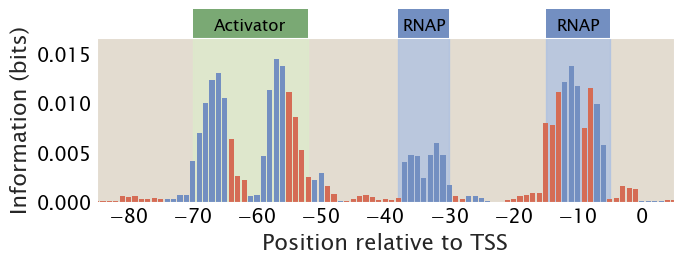

In [7]:
n_NS = len(genome)
n_p = 5000
n_a = 50
ep_wt = -3
ea_wt = -13
e_ap = -10

df = tregs.simulate.sim(promoter, tregs.simulate.simact_pbound, [rnap_site, crp_site], 
                        *[n_NS, n_p, n_a, rnap_emat, crp_emat, ep_wt, ea_wt, e_ap])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -52, 'A', 'Activator')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               annotate_stn=False,
                               x_lims=(-85, 5), fig_width=7,
                               outfile='../plots/fig15/simact.pdf')

### Simple activation using the graph theory approach

In [8]:
def get_weight_gt(seq, energy_mat, e_wt=0):
    '''
    compute the Boltzmann weight, exp(- d_energy / kBT). note that here
    d_energy is already in kBT units and so we don't have to perform the division.

    Args:
        seq (str): sequence of binding site
        energy_mat (arr): energy matrix
        e_wt (int, optional): total binding energy to the wild type binding
        site. Defaults to 0.

    Returns:
        float: Boltzmann weight.
    '''    

    d_energy = tregs.simulate.get_d_energy(seq, energy_mat, e_wt=e_wt)
    
    return np.exp(d_energy)


def simact_graph(p_seq, a_seq, c_p, c_a, p_emat, a_emat,
                 ep_wt, ea_wt, e_ap, U_P_unbinding, U_P_unbinding_with_A,
                 k_on=0.1, C_N=10**7):
    
    k_E_P = k_on
    k_E_A = k_on
    k_A_AP = k_on
    k_P_AP = k_on

    w_p = get_weight_gt(p_seq, p_emat, e_wt=ep_wt) # e^(- \beta \Delta \epsilon_pd)
    w_a = get_weight_gt(a_seq, a_emat, e_wt=ea_wt)
    
    k_P_E = k_E_P * C_N * w_p * np.exp(U_P_unbinding)
    k_A_E = k_E_A * C_N * w_a
    k_AP_P = k_P_AP * C_N * w_a * np.exp(e_ap) 
    k_AP_A = k_A_AP * C_N * w_p * np.exp(e_ap) * np.exp(U_P_unbinding_with_A)

    # weights of each vertex
    rho_E = k_A_E * k_P_E * k_AP_P
    rho_E += k_A_AP * k_AP_P * k_P_E * c_p
    rho_E += k_P_E * k_AP_A * k_A_E
    rho_E += k_A_E * k_AP_A * k_P_AP * c_a

    rho_A = k_AP_P * k_P_E * k_E_A * c_a
    rho_A += k_E_P * k_P_AP * k_AP_A * c_a * c_p
    rho_A += k_P_E * k_E_A * k_AP_A * c_a
    rho_A += k_P_AP * k_AP_A * k_E_A * c_a**2

    rho_P = k_A_E * k_E_P * k_AP_P * c_p
    rho_P += k_E_P * k_A_AP * k_AP_P * c_p**2
    rho_P += k_AP_A * k_A_E * k_E_P * c_p
    rho_P += k_E_A * k_A_AP * k_AP_P * c_a * c_p

    rho_AP = k_A_E * k_E_P * k_P_AP * c_a * c_p
    rho_AP += k_E_P * k_P_AP * k_A_AP * c_a * c_p**2
    rho_AP += k_P_E * k_E_A * k_A_AP * c_a * c_p
    rho_AP += k_E_A * k_A_AP * k_P_AP * c_a**2 * c_p

    p_P = rho_P / (rho_A + rho_E + rho_P + rho_AP)
    p_AP = rho_AP / (rho_A + rho_E + rho_P + rho_AP)

    return p_P + p_AP

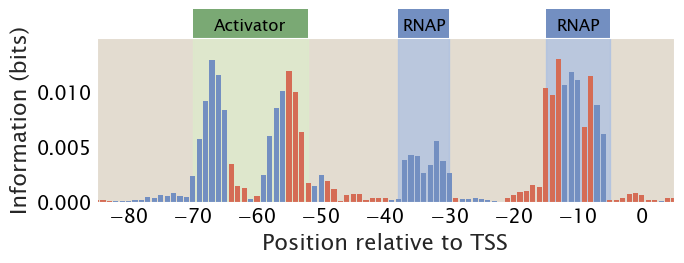

In [9]:
# copy numbers
c_a = 100 # nM
c_p = 5000 # nM

# binding energies
ep_wt = -3
ea_wt = -13
e_ap = -10

U_P_unbinding = 0
U_P_unbinding_with_A = 0

df = tregs.simulate.sim(promoter, simact_graph, [rnap_site, crp_site], 
                        *[c_p, c_a, rnap_emat, crp_emat, ep_wt, ea_wt, e_ap,
                          U_P_unbinding, U_P_unbinding_with_A])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -52, 'A', 'Activator')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               annotate_stn=False,
                               x_lims=(-85, 5), fig_width=7,
                               outfile='../plots/fig15/simact_graph.pdf')

### Breaking detailed balance

Let's break detailed balance at the $k_\mathrm{AP, A}$ edge. Specifically, we let
$$
k_\mathrm{AP, A} = k_\mathrm{AP, A}^\mathrm{eq} * e^{\beta \Delta G},
$$
where $\Delta G$ measures the free energy invested to break detailed balance.

In [10]:
mutant_bank = []
for i in range(1):
    mutants = np.unique(tregs.wgregseq.mutations_rand(promoter,
                                                rate=0.1,
                                                num_mutants=5000,
                                                number_fixed=True,
                                                keep_wildtype=True))
    mutant_bank.append(mutants)

In [11]:
# copy numbers
c_p = 5000 # nM

# binding energies
ep_wt = -3
ea_wt = -13
e_ap = -10

l_c_a = 10 ** np.arange(-6, 6.1, 0.5) # nM
drive = np.arange(-40, 41, 5)

rnap_signal = []
act_signal = []

for U in drive:
    rnap_s = []
    act_s = []
    for c_a in l_c_a:
        rnap = []
        act = []
        for i in range(len(mutant_bank)):
            df = tregs.simulate.sim(promoter, simact_graph, [rnap_site, crp_site], 
                                    *[c_p, c_a, rnap_emat, crp_emat, ep_wt, ea_wt, e_ap, 0, U],
                                    preset_mutants=mutant_bank[i],
                                    scaling_factor=10**6)

            mut_list = df['seq'].values
            mu_data = df['norm_ct_1']
            nbins = 2
            upper_bound = np.median(mu_data)

            footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                        pseudocount=10**(-6))
            rnap_footprint = (np.mean(footprint[(-38+115):(-30+116)]) + np.mean(footprint[(-15+115):(-5+116)]))/2
            act_footprint = np.mean(footprint[(-70+115):(-52+116)])

            exshift = tregs.footprint.get_expression_shift(mut_list, mu_data, promoter)
            rnap_exshift = (np.mean(exshift[(-38+115):(-30+116)]) + np.mean(exshift[(-15+115):(-5+116)]))/2
            act_exshift = np.mean(exshift[(-70+115):(-52+116)])

            rnap_sign = 1 if rnap_exshift <= 0 else -1
            act_sign = 1 if act_exshift <= 0 else -1

            rnap.append(rnap_footprint * rnap_sign)
            act.append(act_footprint * act_sign)
        rnap_s.append(np.mean(rnap))
        act_s.append(np.mean(act))
    rnap_signal.append(rnap_s)
    act_signal.append(act_s)

rnap_signal = np.array(rnap_signal)
act_signal = np.array(act_signal)

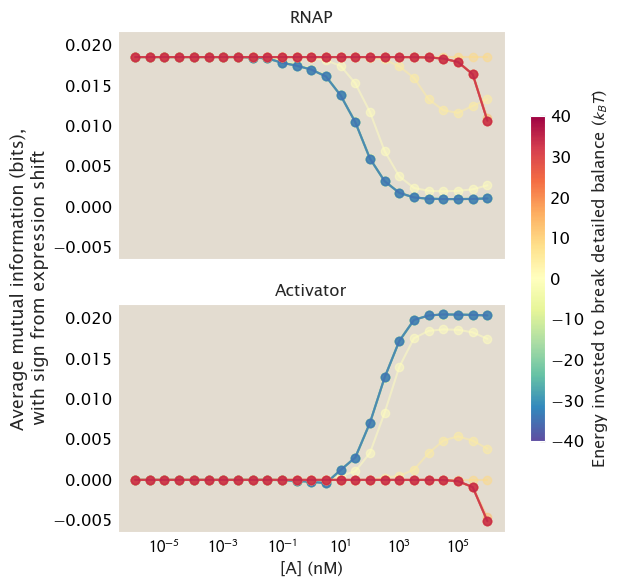

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(5, 6.5), sharey=True, sharex=True)

# Set up Seaborn palette and normalize colors
palette = sns.color_palette("Spectral_r", n_colors=len(drive))
cmap = sns.color_palette("Spectral_r", as_cmap=True)
norm = plt.Normalize(min(drive), max(drive))

zorder = np.concatenate((np.arange(10, 1, -1), np.arange(13, 21, 1)))

for i,d in enumerate(drive):
    rnap_s = rnap_signal[i]
    act_s = act_signal[i]
    axes[0].plot(l_c_a, rnap_s, 'o-', color=palette[i], zorder=zorder[i], alpha=0.5)
    axes[1].plot(l_c_a, act_s, 'o-', color=palette[i], zorder=zorder[i], alpha=0.5)

# Create colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Customize the placement of the colorbar
cbar_ax = fig.add_axes([0.95, 0.25, 0.03, 0.5])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Energy invested to break detailed balance ($k_BT$)')

# Setting custom ticks for log scale
tick_positions = [10**-5, 10**-3, 10**-1, 10**1, 10**3, 10**5]
tick_labels = ['$10^{-5}$', '$10^{-3}$', '$10^{-1}$', '$10^1$', '$10^3$', '$10^5$']

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[0].set_xticks(tick_positions)
axes[0].set_xticklabels(tick_labels)
axes[1].set_xticks(tick_positions)
axes[1].set_xticklabels(tick_labels)

axes[1].set_xlabel('[A] (nM)')
axes[0].set_title('RNAP', fontsize=12)
axes[1].set_title('Activator', fontsize=12)

# Add a big central Y axis label
fig.text(-0.09, 0.5, 'Average mutual information (bits),\n with sign from expression shift',
         va='center', rotation='vertical', fontsize=13)

plt.savefig('../plots/fig15/simact_graph_mutants.pdf', bbox_inches='tight')
plt.show()

**What are the physiological relevant ranges of concentrations? Noise becomes noticeably high when $c_a > 10^6$**

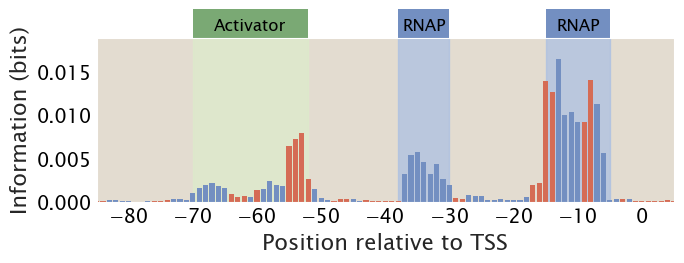

In [13]:
# copy numbers
c_a = 10 # nM
c_p = 5000 # nM

# binding energies
ep_wt = -3
ea_wt = -13
e_ap = -10

U_P_unbinding = 0
U_P_unbinding_with_A = -40

df = tregs.simulate.sim(promoter, simact_graph, [rnap_site, crp_site], 
                        *[c_p, c_a, rnap_emat, crp_emat, ep_wt, ea_wt, e_ap,
                          U_P_unbinding, U_P_unbinding_with_A])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -52, 'A', 'Activator')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               annotate_stn=False,
                               x_lims=(-85, 5), fig_width=7,
                               outfile='../plots/fig15/simact_graph_broken1.pdf')

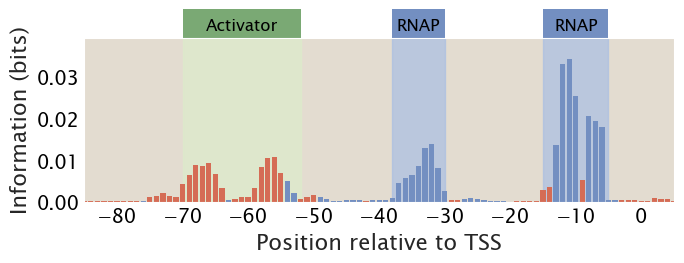

In [14]:
# copy numbers
c_a = 10**(6) # nM
c_p = 5000 # nM

# binding energies
ep_wt = -3
ea_wt = -13
e_ap = -10

U_P_unbinding = 0
U_P_unbinding_with_A = 40

df = tregs.simulate.sim(promoter, simact_graph, [rnap_site, crp_site], 
                        *[c_p, c_a, rnap_emat, crp_emat, ep_wt, ea_wt, e_ap,
                          U_P_unbinding, U_P_unbinding_with_A],
                          scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -52, 'A', 'Activator')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               annotate_stn=False,
                               x_lims=(-85, 5), fig_width=7,
                               outfile='../plots/fig15/simact_graph_broken2.pdf')